# Vertex AI: AutoML Image Classification - Model Predictions (Edge + Cloud) with GCS Bucket

Contributors: michaelmenzel@

This Colab facilitates test predictions with Cloud AutoML Vision generated models for image classification. The model can be queried on classifications of test images, either in the cloud or offline as exported model.

Parameters needed are as minimal as possible, and you only need to provide:
- Project ID: project where the AutoML model was training.
- Model ID: the identifier of the trained model which can be found in the AutoML UI and API.
- Region: region the model was created in.
- Example Images: a Cloud Storage URI (with wildcards) to example images for test predictions.
- Max. Images: the number of images to load from the example images storage location.
- Model Export Destination: a Cloud Storage URI to export the model to.

In [ ]:
#@title Mandatory Libraries
!pip uninstall -q -y pandas-gbq > /dev/null 2>&1
!pip install -q google-cloud-aiplatform saliency > /dev/null 2>&1

print('Next the runtime is restarted. This cell may show an error. Please continue regardless.')
print('Killing runtime to activate libraries...')

import time
import os
time.sleep(1)
os.kill(os.getpid(), 9)

Next the runtime is restarted. This cell may show an error. Please continue regardless.
Killing runtime to activate libraries...


In [5]:
#@title Parameters

import base64
import json
import os
import tempfile

import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import saliency

from tqdm import tqdm
from joblib import Parallel, delayed

from google.cloud import aiplatform as aiplatform, storage

project_id = 'sandbox-michael-menzel' #@param {type:"string"}
model_id = '2657044615311392768' #@param {type:"string"}
region = 'us-central1' #@param {type: "string"}
example_images = 'gs://automl-clouds-michael-menzel/test/*.jpg' #@param {type:"string"}
max_images = 500 #@param {type:"integer"}
model_export_destination = 'gs://automl-clouds-michael-menzel/models/' #@param {type:"string"}

service_account_name='automl-vision-icn-sa'

In [6]:
#@title Authenticate

#@title Run this code to authenticate & obtain credentials [RUN]
!gcloud config set project $project_id
import googleapiclient.discovery
from google.oauth2 import service_account

from google.colab import auth
auth.authenticate_user()

Updated property [core/project].


In [7]:
#@title Clients & Helpers
client_options = {"api_endpoint": f"{region}-aiplatform.googleapis.com"}

aipm_client = aiplatform.gapic.ModelServiceClient(client_options=client_options)
aipe_client = aiplatform.gapic.EndpointServiceClient(client_options=client_options)
aipp_client = aiplatform.gapic.PredictionServiceClient(client_options=client_options)
gcs_client = storage.Client(project=project_id)

model_full_id = aipm_client.model_path(project_id, region, model_id)
parent = f"projects/{project_id}/locations/{region}"

def get_image(gcs_uri):
  _, tf = tempfile.mkstemp()
  with open(tf, 'wb') as df:
    gcs_client.download_blob_to_file(example_image, df)

  with open(tf, 'rb') as df:
    return tf, df.read()

  return None, None

def plot_image(img_path):
  plt.imshow(plt.imread(tf.io.gfile.GFile(img_path, 'rb')))
  plt.axis('off')
  plt.show()

def plot_tensor(img_tensor, cmap=None):
  plt.imshow(img_tensor, cmap=cmap)
  plt.axis('off')
  plt.show()

def plot_tensor_overlay(img_tensor, overlay_tensor, alpha=0.5, cmap=None):
  plt.imshow(img_tensor)
  plt.imshow(overlay_tensor, alpha=alpha, cmap=cmap)
  plt.axis('off')
  plt.show() 

def model_details(model_full_id):
  request = aiplatform.gapic.GetModelRequest(name=model_full_id)
  model = aipm_client.get_model(request)
  print(f'Retrieved details of model {model_full_id}')
  return model

def deploy_model(model_full_id):
  model = model_details(model_full_id)
  existing_eps = list(aipe_client.list_endpoints(request={"parent": parent, "filter": "display_name=\"" + model.display_name + "_ep\""}))
  if len(existing_eps) > 0:
    ep_id = existing_eps[0].name
  else:
    ep_job = aipe_client.create_endpoint(parent=parent, endpoint={"display_name": model.display_name + "_ep"})
    ep_id = ep_job.result().name
    print(f'Created endpoint {ep_id}.')

    deploy_job = aipe_client.deploy_model(
        endpoint=ep_id, 
        traffic_split={'0': 100},
        deployed_model=aiplatform.gapic.DeployedModel(
            model=model_full_id,
            automatic_resources=aiplatform.gapic.AutomaticResources(min_replica_count=1, max_replica_count=1)))
    deploy_job.result()
    print(f'Deployed model {model_full_id} to endpoint {ep_id}.')

  return ep_id

def get_prediction(content, endpoint_id):
  return aipp_client.predict(endpoint=endpoint_id, instances=[{'content': content}])

def predict(gcs_uri, endpoint_id):
  return get_prediction(base64.b64encode(tf.io.read_file(gcs_uri).numpy()).decode('utf-8'), endpoint_id)

def export_model(model_full_id, format='tf-saved-model'):
  output_config = aiplatform.gapic.ExportModelRequest.OutputConfig(
      artifact_destination=aiplatform.gapic.GcsDestination(output_uri_prefix=os.path.join(model_export_destination, model_id)),
      export_format_id=format
    )

  export_request = aiplatform.gapic.ExportModelRequest(name=model_full_id, output_config=output_config)
  export_job = aipm_client.export_model(request=export_request)
  export_job.result()

  gcs_source = export_job.metadata.output_info.artifact_output_uri
  local_dest = tempfile.mkdtemp()
  !gsutil -m cp -r $gcs_source/** $local_dest
  print('Stored exported model to folder:', local_dest)
  return gcs_source, local_dest

def load_model(model_file):
  tf_model = tf.saved_model.load(model_file, tags=['serve']).signatures['serving_default']
  print('Input Signature:', tf_model.structured_input_signature)
  print('Output Signature:', tf_model.structured_outputs)

  return tf_model

## Deploy Model

In [8]:
endpoint_id = deploy_model(model_full_id)

Retrieved details of model projects/sandbox-michael-menzel/locations/us-central1/models/2657044615311392768


## Model Export

In [9]:
gcs_export_model_location, model_file = export_model(model_full_id)
local_model = load_model(model_file)

Copying gs://automl-clouds-michael-menzel/models/2657044615311392768/model-2657044615311392768/tf-saved-model/2021-10-01T09:31:58.348337Z/saved_model.pb...
/ [1/1 files][ 22.6 MiB/ 22.6 MiB] 100% Done                                    
Operation completed over 1 objects/22.6 MiB.                                     
Stored exported model to folder: /tmp/tmpvg795rhz
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
Input Signature: ((), {'image_bytes': TensorSpec(shape=(None,), dtype=tf.string, name='image_bytes'), 'key': TensorSpec(shape=(None,), dtype=tf.string, name='key')})
Output Signature: {'scores': <tf.Tensor 'scores:0' shape=(None, 3) dtype=float32>, 'labels': <tf.Tensor 'Tile:0' shape=(None, 3) dtype=string>, 'key': <tf.Tensor 'Identity:0' shape=(None,) dtype=string>}


## Test Predictions

In [10]:
#@title Prediction Helpers
def test_image_remote(example_image, endpoint_id, with_plot=False):
  result = predict(example_image, endpoint_id)

  labels = result.predictions[0]['displayNames']
  scores = result.predictions[0]['confidences']
  max_score = max(scores)
  max_score_arg = tf.argmax(scores).numpy()
  max_label = labels[max_score_arg]

  outputs = {label: scores[i] for i, label in enumerate(labels)}

  if with_plot:
    plot_image(example_image)
    print(f"{example_image} -> class: {max_label} with confidence: {max_score}")
  return {'image': example_image, 'max': max_label, **outputs}

def test_image_local(example_image, threshold=.8, with_plot=False):
  local_annotation = local_model(key=tf.constant(['test']), image_bytes=tf.expand_dims(tf.io.read_file(example_image), -1))

  labels = local_annotation['labels'][0].numpy()
  scores = local_annotation['scores'][0].numpy()
  max_score = max(scores)
  max_score_arg = tf.argmax(scores).numpy()
  max_label = str(labels[max_score_arg], encoding='utf-8') if max_score > threshold else 'pass'
  #str(tf.squeeze(labels)[max_score_arg].numpy(), encoding='utf-8')

  outputs = {str(label, encoding='utf-8'): scores[i] for i, label in enumerate(labels)}

  if with_plot:
    plot_image(example_image)
    print(f"{example_image} -> class: {max_label} with confidence: {max_score}")
  return {'image': example_image, 'max': max_label, **outputs}

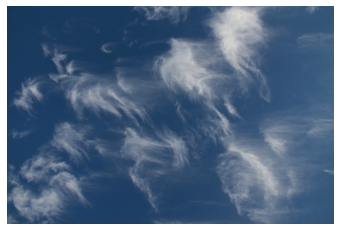

gs://automl-clouds-michael-menzel/test/cirrus_10.jpg -> class: cirrus with confidence: 0.933313847


In [11]:
result_remote = test_image_remote(tf.io.gfile.glob(example_images)[0], endpoint_id, with_plot=True)

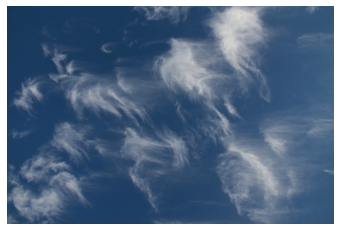

gs://automl-clouds-michael-menzel/test/cirrus_10.jpg -> class: cirrus with confidence: 0.9360285401344299


In [12]:
result_local = test_image_local(tf.io.gfile.glob(example_images)[0], with_plot=True)

## Test with All Example Images

In [15]:
df_remote = pd.DataFrame(Parallel(n_jobs=16, backend='threading')(delayed(test_image_remote)(example_image, endpoint_id) for example_image in tqdm(tf.io.gfile.glob(example_images)[:max_images])))
df_remote

100%|██████████| 6/6 [00:00<00:00, 14471.43it/s]


,image,max,cumulonimbus,cumulus,cirrus
0,gs://automl-clouds-michael-menzel/test/cirrus_...,cirrus,0.033047,0.033639,0.933314
1,gs://automl-clouds-michael-menzel/test/cirrus_...,cirrus,0.037071,0.038413,0.924516
2,gs://automl-clouds-michael-menzel/test/cumulon...,cumulonimbus,0.933828,0.031911,0.034261
3,gs://automl-clouds-michael-menzel/test/cumulon...,cumulonimbus,0.944023,0.028486,0.027491
4,gs://automl-clouds-michael-menzel/test/cumulus...,cumulus,0.031440,0.936556,0.032004
5,gs://automl-clouds-michael-menzel/test/cumulus...,cumulus,0.027020,0.944480,0.028500


In [16]:
df_local = pd.DataFrame(Parallel(n_jobs=16, backend='threading')(delayed(test_image_local)(example_image, threshold=0.) for example_image in tqdm(tf.io.gfile.glob(example_images)[:max_images])))
df_local

100%|██████████| 6/6 [00:00<00:00, 18078.90it/s]


,image,max,cumulonimbus,cumulus,cirrus
0,gs://automl-clouds-michael-menzel/test/cirrus_...,cirrus,0.031986,0.031986,0.936029
1,gs://automl-clouds-michael-menzel/test/cirrus_...,cirrus,0.037737,0.037737,0.924527
2,gs://automl-clouds-michael-menzel/test/cumulon...,cumulonimbus,0.937548,0.029839,0.032612
3,gs://automl-clouds-michael-menzel/test/cumulon...,cumulonimbus,0.937001,0.033177,0.029822
4,gs://automl-clouds-michael-menzel/test/cumulus...,cumulus,0.031404,0.935473,0.033123
5,gs://automl-clouds-michael-menzel/test/cumulus...,cumulus,0.027970,0.943558,0.028472
